# **Image Segmentation**

In [1]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-nnpa0y9j
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-nnpa0y9j
  Resolved https://github.com/albumentations-team/albumentations to commit cbb00e88030ba274e0bcca0953fb756cff21a510
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [3]:
import sys
import albumentations as A
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
fp = '/content/Human-Segmentation-Dataset-master/train.csv'
dir = '/content'

device = 'cuda'
epochs = 25
learning_rate = 0.003
image_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [6]:
df = pd.read_csv(fp)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
row_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(row_path, cv2.IMREAD_GRAYSCALE) / 255.0

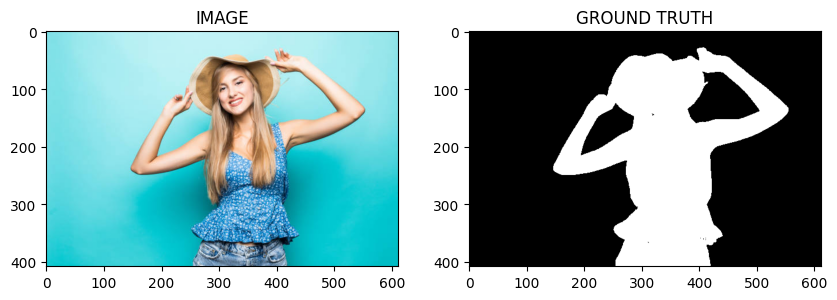

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
def get_train_augs():
    return A.Compose([
        A.Resize(image_size, image_size), # Resize before other augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(image_size, image_size) # Resize before other augmentations
    ])

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__ (self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize before augmentations
        image = cv2.resize(image, (image_size, image_size))
        mask = cv2.resize(mask, (image_size, image_size))

        mask = np.expand_dims(mask, axis=-1) # Add channel dimension to mask

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # (h w c) to (c h w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [13]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
print(f'Size of Trainset: {len(trainset)}')
print(f'Size of Validset: {len(validset)}')

Size of Trainset: 232
Size of Validset: 58


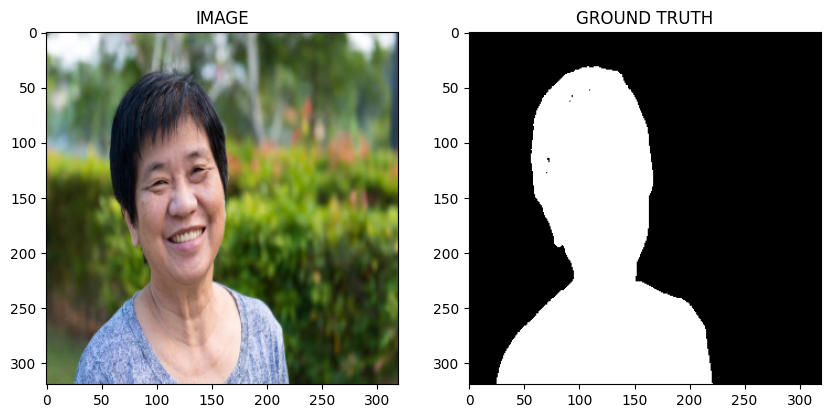

In [15]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)


In [16]:
from torch.utils.data import DataLoader

In [17]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [18]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [19]:
for image, mask in trainloader:
  break

print(f'image shape: {image.shape}')
print(f'mask shape: {mask.shape}')


image shape: torch.Size([16, 3, 320, 320])
mask shape: torch.Size([16, 1, 320, 320])
